# Insights from Failed Orders
---

## Table of Contents
<ul>
<li><a href="#questions">Questions</a></li>
<li><a href="#datadescription">Data Description</a></li>
<li><a href="#EDA">Exploratory Data Analysis</a></li>
<li><a href="#datainsights">Data Insights</a></li>
    <ol>
        <li><a href="#Q1">Question 1</a></li>
        <li><a href="#Q2">Question 2</a></li>
        <li><a href="#Q3">Question 3</a></li>
        <li><a href="#Q4">Question 4</a></li>
    </ol>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

---

<a id="questions"></a>
## Questions

1. Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

2. Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

3. Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

4. Plot the distribution of average ETA by hours. How can this plot be explained?

---

<a id="datadescription"></a>
## Data Description

2 datasets: `data_orders` and `data_offers` being stored in CSV format are provided. 

The dataset `data_orders` contain:
- `order_datetime` - time of the order
- `origin_longtitude` - longtitude of the order
- `origin_latitude` - latitude of the order
- `m_order_eta` - time before order arrival
- `order_gk` - order number
- `order_status_key` - status of the order
    - `4` - cancelled by clinet, 
    - `9` - cancelled by system (a reject)
- `is_driver_assigned_key` - whether a driver has been assigned
- `cancellation_time_in_seconds` - how many seconds passed before cancellation

The dataset `data_offers` contain:
- `order_gk` - order number, associated with the same column from the `orders` dataset
- `origin_id` - ID of an offer

---

<a id="EDA"></a>
## Exploratory Data Analysis

In [1]:
# Impoer libraries
import pandas as pd
import numpy as np

In [ ]:
# Import Orders data
orders = pd.read_csv(filepath_or_buffer="datasets/data_orders.csv")

In [3]:
# Display the first 5 rows of the DataFrame
orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [ ]:
# rows + columns
orders.shape

(10716, 8)

In [6]:
# Basic information about the DataFrame
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


In [8]:
# Import Offers data
offers = pd.read_csv(filepath_or_buffer="datasets/data_offers.csv")

In [9]:
# Display the first 5 rows of the DataFrame
offers.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [10]:
# rows + columns
offers.shape

(334363, 2)

In [11]:
# Basic information about the DataFrame
offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334363 entries, 0 to 334362
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   order_gk  334363 non-null  int64
 1   offer_id  334363 non-null  int64
dtypes: int64(2)
memory usage: 5.1 MB


As both datasets contain `orders` column in common, we will merge them into one DataFrame for data manipulation. 

In [ ]:
# Merge the two DataFrames on the 'order_gk' column
df = orders.merge(right=offers, how='inner', on='order_gk')

In [13]:
# Display the first 5 rows of the merged DataFrame
df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,300050983403
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986179
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986174
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986180
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,300050976275


In [14]:
# Rename the 'order_datetime' column to 'order_time'
df.rename(columns={'order_datetime': 'order_time'},inplace=True)

The current values in two columns `order_status_key` and `is_driver_assigned_key` are not informative enough as they are in the forms of keys that relate to internal description. 

Therefore, the quality of the combined dataframe can be improved by mapping the current values with more meaningful ones such as `1` with `Yes` and `0` with `No`.

In [15]:
# Encode nominal categorical variables using one-hot encoding
df["is_driver_assigned"] = np.where(df["is_driver_assigned_key"] == 1, "Yes", "No")
df["order_status"] = np.where(df["order_status_key"] == 4, "Client Cancelled", "System Reject")

In [16]:
# Drop the original key columns
df.drop(columns=["is_driver_assigned_key", "order_status_key"], inplace=True)

In [17]:
# Display the first 5 rows of the refined DataFrame
df.head()

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,cancellations_time_in_seconds,offer_id,is_driver_assigned,order_status
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,198.0,300050983403,Yes,Client Cancelled
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986179,No,Client Cancelled
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986174,No,Client Cancelled
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986180,No,Client Cancelled
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,46.0,300050976275,Yes,Client Cancelled


At this point, the combined dataframe is ready for analysing.

<a id="datainsights"></a>
## Data Insights

<a id="Q1"></a>
### **Question 1**

**Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?**

To build a distribution based on two types of reasons for failure, a pivot table is recommended as each column has only 2 possible values. Therefore, 4 possible combinations of values can be generated. 

In [ ]:
df_gb1 = df.groupby(by=["is_driver_assigned","order_status"])["order_gk"].count()
df_gb1

is_driver_assigned  order_status    
No                  Client Cancelled    13435
                    System Reject        9469
Yes                 Client Cancelled     8360
                    System Reject           4
Name: order_gk, dtype: int64

It is clear that a higher number of cancelled orders happen before a driver is successfully assigned, indicating that highly due to long waiting time, customers decided on transportation alterantives. Specifically, `13435` orders were cancelled by client and `9469` by the system. There are `8360` orders cancelled by client and only `4` by the system after a driver was assigned. 

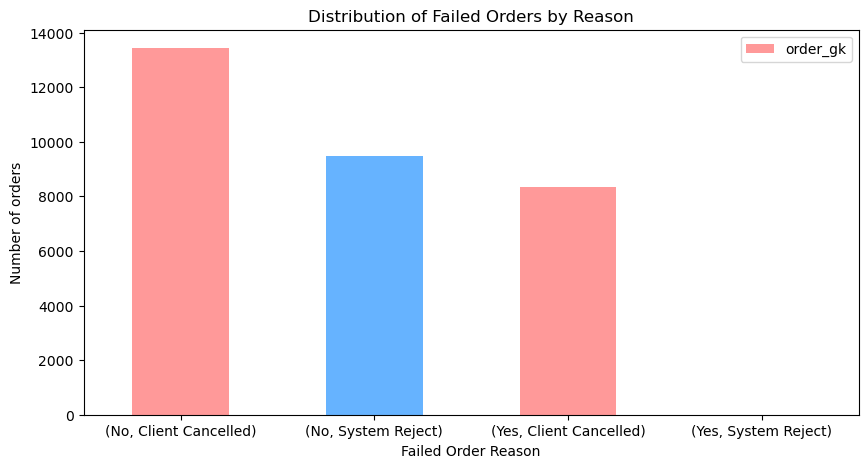

In [ ]:
_ = df_gb1.plot(kind="bar", 
                       subplots=False,
                       ylabel='Number of orders', 
                       xlabel='Failed Order Reason',
                       title='Distribution of Failed Orders by Reason',
                       color=['#FF9999', '#66B3FF'],
                       figsize=(10, 5), 
                       legend=True, 
                       rot=0)

<a id="Q2"></a>
### **Question 2**

**Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?**

As the question is focused on analysing the distribution of failed orders by hours, the hour number must be extracted from the `order_time` column firstly.

In [ ]:
# Statistics of the 'order_time' column
df['order_time'].describe()

count        31268
unique        7183
top       23:36:03
freq            24
Name: order_time, dtype: object

The current data type is Object and numbers are separated by `:`; therefore, we need to extract the first 2 numbers recognised as the hour.

In [29]:
# Extract the hour from the 'order_time' column
df["order_hour"] = df["order_time"].str.split(":").apply(lambda split: split[0])

In [30]:
# Display the first 5 rows of the DataFrame with the new 'order_hour' column
df[["order_time","order_hour"]].head()

,order_time,order_hour
0,18:08:07,18
1,20:57:32,20
2,20:57:32,20
3,20:57:32,20
4,12:07:50,12


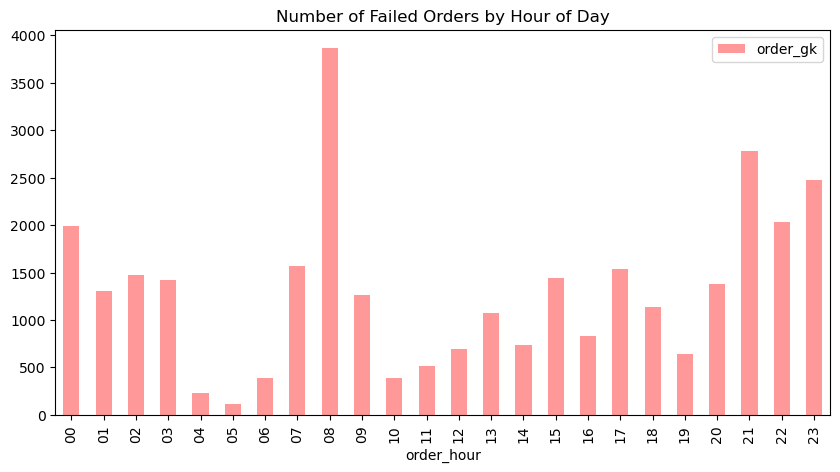

In [33]:
# Plot the count of failed orders by hour of the day
_ = df.groupby(by="order_hour")["order_gk"].count().plot(kind='bar',
                                                         figsize=(10, 5), 
                                                         color="#FF9999",
                                                         legend=True,
                                                         title="Number of Failed Orders by Hour of Day")

From the bar chart above , it is seen that the biggest fails occurred at `8:00`,followed by `21:00` and `23:00`

Failed orders are further investigated by hour by category, to obtain deeper insights into the cancelations by category.

In [ ]:
# Group the DataFrame by 'order_hour', 'is_driver_assigned', and 'order_status' and count the number of orders
df_gb2 = df.groupby(by=["order_hour","is_driver_assigned","order_status"])["order_gk"].count()
df_gb2.head(10)

order_hour  is_driver_assigned  order_status    
00          No                  Client Cancelled    957
                                System Reject       706
            Yes                 Client Cancelled    326
                                System Reject         4
01          No                  Client Cancelled    633
                                System Reject       374
            Yes                 Client Cancelled    298
02          No                  Client Cancelled    586
                                System Reject       649
            Yes                 Client Cancelled    240
Name: order_gk, dtype: int64

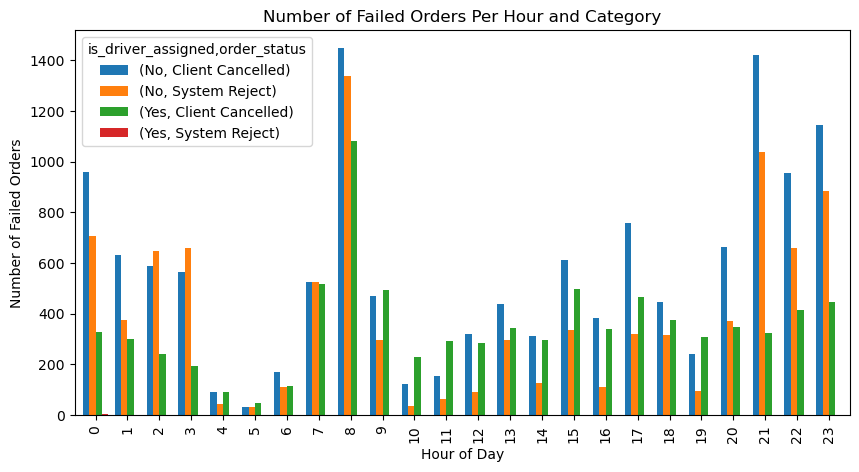

In [ ]:
# Plot the count of failed orders by hour of the day, driver assignment status, and order status
_ = df_gb2.reset_index().pivot(index="order_hour",
                            columns=["is_driver_assigned", "order_status"],
                            values="order_gk").plot(kind="bar",
                                                    xticks=range(0, 24),
                                                    figsize=(10, 5),
                                                    width=0.8,
                                                    xlabel="Hour of Day",
                                                    ylabel="Number of Failed Orders",
                                                    title="Number of Failed Orders Per Hour and Category")

**Peak Failure Hours**:

- The highest number of failed orders occur around **_8 AM and 8–9 PM_**.

- These may coincide with rush hours or times of high demand, possibly overwhelming the system or leading to higher cancellation rates.

**Client Cancellations Dominate**:

- For both `is_driver_assigned = No and Yes`, "Client Cancelled" orders are more frequent than "System Reject".

- This suggests user behavior (perhaps long wait times or change of mind) is a major reason for failed orders.

**No Driver Assigned = More Failures**:

- Categories with `is_driver_assigned = No` consistently have more failed orders than those where a driver was assigned → a possible supply issue as not enough drivers are there to meet demand.

**Early Morning Hours (1 AM – 6 AM)**:

- The number of failed orders is significantly lower in early morning hours, which is expected due to lower order volume.

**Similar Trends in Client Behavior**:

- When a driver is assigned, client cancellations still occur in notable numbers (e.g., **_around 8 AM and 8 PM_**), meaning:

    - Assignment of a driver doesn’t fully prevent client-side cancellations.

    - May indicate issues like _delayed driver arrival, miscommunication, or last-minute plan changes_.

System Rejects:

- System rejects happen less often, but still visibly spike during high-demand times.

- Could be related to _automated checks or platform limits_ (e.g., location restrictions, payment issues, etc.).

<a id="Q3"></a>
### **Question 3**

**Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?**

<a id="Q4"></a>
### **Question 4**

**Plot the distribution of average ETA by hours. How can this plot be explained?**